## Spatial analysis of Zurich

We implement spatial analysis to extract relevant information from the association of Zurich zip-code level averaged insurance data metrics with the indicators for the city of Zurich previously constructed.

In [196]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pysal as ps
import seaborn as sns

In [197]:
DATA_FOLDER = "./data/"

#read zips geometry data
zips = gpd.read_file( DATA_FOLDER + "shapeFiles/zips.shp")
zips.columns = ['UUID', 'OS_UUID', 'STATUS', 'INAEND', 'ZIP', 'ZUSZIFF','geometry']

# read data previously cleaned, aggregated and merged
zurich_indicators_df = pd.read_csv(DATA_FOLDER + 'zurich_indicators.csv', index_col=0)
insurance_avg_df = pd.read_csv(DATA_FOLDER + 'zurich_insurance_averages.csv', index_col=0)
insurance_jobs_avg_df = pd.read_csv(DATA_FOLDER + 'insurance_jobs_avgs.csv', index_col=0)

display(zurich_indicators_df.head())
display(insurance_avg_df.head())
display(insurance_jobs_avg_df.head())

,safety_indic,hospitality_indic,handicapp_indic,parks_indic,pf_indic,cc_indic,sf_indic,cf_indic
8050,0.030897,-0.004573,0.057086,-0.010871,-0.069738,-0.006650,0.026753,0.060253
8049,-0.022621,-0.098503,-0.088325,-0.014034,-0.099443,-0.084240,-0.084932,-0.007254
8048,-0.023800,-0.033503,0.033034,-0.110341,-0.106258,-0.034871,0.132786,0.009932
8032,0.000955,-0.059359,-0.023114,-0.072792,-0.007547,-0.062333,-0.110309,0.005162
8046,-0.032635,-0.098414,-0.102853,-0.057837,-0.149956,-0.007862,-0.000254,-0.010371


,Avg_Children_0-26,Avg_Car_Premium,Avg_num_cars,Avg_total_car_spending,Avg_property_premium,Avg_Age,Avg_Stand_of_furn,Avg_Rooms
8001,0.114327,246.777135,0.159190,8719.247467,135399.421129,52.795948,0.626628,1.008683
8002,0.159195,289.970082,0.208600,9797.804209,117795.974382,47.647758,0.731016,1.372827
8003,0.091236,156.687635,0.146459,5384.153661,60006.402561,41.789516,0.821529,1.521409
8004,0.100722,154.187402,0.140409,5134.395670,60840.950090,42.186109,0.682502,1.269092
8005,0.142173,186.035184,0.158449,6700.813787,77629.487793,42.348492,0.779799,1.502633


,%JobState_Angestellt,%JobState_Arbeitslos,%JobState_Hausfrau,%JobState_Rentner,%JobState_Selbstständig,%JobState_Student,%JobState_Unknown
8001_,62.373372,0.434153,1.013025,12.445731,9.985528,4.486252,9.261939
8002_,67.795059,0.000000,1.372370,9.789570,4.757548,4.117109,12.168344
8003_,74.709884,0.280112,0.320128,4.161665,3.601441,7.963185,8.963585
8004_,72.609741,0.661455,0.601323,4.930848,3.908599,6.554420,10.733614
8005_,74.533270,0.574438,0.478698,2.967927,3.973193,4.882719,12.589756


In [198]:
# take only zips for insurance data
insurance_avg_zips_df = insurance_avg_df.drop(['Zurich'])
insurance_avg_zips_df.index=pd.to_numeric(insurance_avg_zips_df.index)

# merge the qol indicators and the insurance data
city_people_df = pd.merge(zurich_indicators_df,insurance_avg_zips_df, how='inner', left_index=True, right_index=True)

# add geometry information for each zip 
city_people_df = pd.merge(city_people_df, zips[['ZIP', 'geometry']].set_index('ZIP'), 'inner', left_index=True,right_index=True)
city_people_df = city_people_df.drop_duplicates('safety_indic')
city_people_df.index

Int64Index([8001, 8002, 8003, 8004, 8005, 8006, 8008, 8032, 8037, 8038, 8041,
            8044, 8045, 8046, 8047, 8048, 8049, 8050, 8051, 8052, 8053, 8055,
            8057, 8064],
           dtype='int64')

### Correlation between city and people metrics

In [199]:
from scipy.stats import pearsonr

city_people_df = city_people_df.drop([8001]).drop(columns=['pf_indic','cc_indic','cf_indic']).rename(columns={'sf_indic':'sports_indic'})

df1 = city_people_df.drop(columns='geometry')
df2 = city_people_df.drop(columns='geometry')

coeffmat = np.zeros((df1.shape[1], df2.shape[1]))
pvalmat = np.zeros((df1.shape[1], df2.shape[1]))

for i in range(df1.shape[1]):    
    for j in range(df2.shape[1]):        
        corrtest = pearsonr(df1[df1.columns[i]], df2[df2.columns[j]])  

        coeffmat[i,j] = corrtest[0]
        pvalmat[i,j] = corrtest[1]

dfcoeff = pd.DataFrame(coeffmat, columns=df2.columns, index=df1.columns)
display(dfcoeff)

dfpvals = pd.DataFrame(pvalmat, columns=df2.columns, index=df1.columns)
display(dfpvals)

,safety_indic,hospitality_indic,handicapp_indic,parks_indic,sports_indic,Avg_Children_0-26,Avg_Car_Premium,Avg_num_cars,Avg_total_car_spending,Avg_property_premium,Avg_Age,Avg_Stand_of_furn,Avg_Rooms
safety_indic,1.000000,0.824535,0.571500,-0.312667,-0.310730,-0.654967,-0.383042,-0.530853,-0.301727,-0.235723,-0.659551,-0.413679,-0.552184
hospitality_indic,0.824535,1.000000,0.609746,-0.312496,-0.241887,-0.746151,-0.565523,-0.660992,-0.489979,-0.374579,-0.804502,-0.459741,-0.656839
handicapp_indic,0.571500,0.609746,1.000000,0.096907,-0.225475,-0.411982,-0.063858,-0.351012,0.093284,0.319088,-0.373813,-0.038914,-0.248054
parks_indic,-0.312667,-0.312496,0.096907,1.000000,0.269112,0.566424,0.374914,0.257794,0.398080,0.455536,0.440358,0.147894,0.207840
sports_indic,-0.310730,-0.241887,-0.225475,0.269112,1.000000,0.439491,0.370086,0.552678,0.308696,-0.173263,0.301312,-0.184148,0.119380
Avg_Children_0-26,-0.654967,-0.746151,-0.411982,0.566424,0.439491,1.000000,0.615068,0.727340,0.543540,0.306903,0.673882,0.271827,0.631886
Avg_Car_Premium,-0.383042,-0.565523,-0.063858,0.374914,0.370086,0.615068,1.000000,0.915781,0.974042,0.600937,0.766721,0.476858,0.596270
Avg_num_cars,-0.530853,-0.660992,-0.351012,0.257794,0.552678,0.727340,0.915781,1.000000,0.824077,0.313074,0.747007,0.366745,0.634617
Avg_total_car_spending,-0.301727,-0.489979,0.093284,0.398080,0.308696,0.543540,0.974042,0.824077,1.000000,0.714814,0.733216,0.505148,0.564418
Avg_property_premium,-0.235723,-0.374579,0.319088,0.455536,-0.173263,0.306903,0.600937,0.313074,0.714814,1.000000,0.635457,0.629958,0.431741


,safety_indic,hospitality_indic,handicapp_indic,parks_indic,sports_indic,Avg_Children_0-26,Avg_Car_Premium,Avg_num_cars,Avg_total_car_spending,Avg_property_premium,Avg_Age,Avg_Stand_of_furn,Avg_Rooms
safety_indic,0.000000,0.000001,0.004389,0.146338,0.148989,0.000695,7.121817e-02,9.154838e-03,1.617534e-01,0.278899,0.000618,0.049737,0.006295
hospitality_indic,0.000001,0.000000,0.002008,0.146571,0.266150,0.000044,4.918808e-03,5.952906e-04,1.762652e-02,0.078239,0.000004,0.027304,0.000662
handicapp_indic,0.004389,0.002008,0.000000,0.660031,0.300932,0.050776,7.722209e-01,1.005364e-01,6.720396e-01,0.137791,0.078899,0.860071,0.253773
parks_indic,0.146338,0.146571,0.660031,0.000000,0.214345,0.004836,7.795087e-02,2.349926e-01,5.993573e-02,0.028934,0.035471,0.500667,0.341286
sports_indic,0.148989,0.266150,0.300932,0.214345,0.000000,0.035877,8.217182e-02,6.239215e-03,1.518078e-01,0.429174,0.162360,0.400280,0.587443
Avg_Children_0-26,0.000695,0.000044,0.050776,0.004836,0.035877,0.000000,1.787237e-03,8.411545e-05,7.348124e-03,0.154325,0.000423,0.209579,0.001219
Avg_Car_Premium,0.071218,0.004919,0.772221,0.077951,0.082172,0.001787,0.000000e+00,8.948164e-10,4.979579e-15,0.002425,0.000020,0.021411,0.002675
Avg_num_cars,0.009155,0.000595,0.100536,0.234993,0.006239,0.000084,8.948164e-10,0.000000e+00,1.342745e-06,0.145785,0.000042,0.085191,0.001143
Avg_total_car_spending,0.161753,0.017627,0.672040,0.059936,0.151808,0.007348,4.979579e-15,1.342745e-06,0.000000e+00,0.000127,0.000069,0.013947,0.005022
Avg_property_premium,0.278899,0.078239,0.137791,0.028934,0.429174,0.154325,2.425407e-03,1.457853e-01,1.267621e-04,0.000000,0.001121,0.001275,0.039671


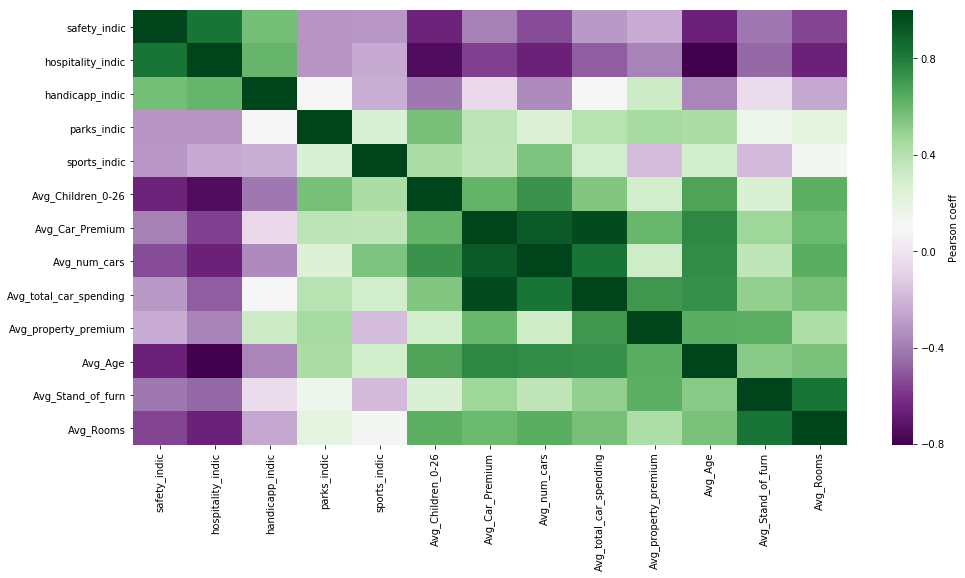

In [201]:
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(dfcoeff, 
        xticklabels=dfcoeff.columns,
        yticklabels=dfcoeff.columns, cmap='PRGn',cbar_kws={'label': 'Pearson coeff'})


### Corrrelation between city metrics and customer jobs info


In [87]:
insurance_jobs_avg_df2 = insurance_jobs_avg_df.drop(['Zurich_'])
insurance_jobs_avg_df2.index=insurance_jobs_avg_df2.index.map(lambda x: str(x).rstrip('_'))
insurance_jobs_avg_df2.index=pd.to_numeric(insurance_jobs_avg_df2.index)

city_jobs_df = pd.merge(zurich_indicators_df,insurance_jobs_avg_df2, how='inner', left_index=True, right_index=True)

# add geometry information for each zip 
city_jobs_df = pd.merge(city_jobs_df, zips[['ZIP', 'geometry']].set_index('ZIP'), 'inner', left_index=True,right_index=True)
city_jobs_df = city_jobs_df.drop_duplicates('safety_indic')

In [88]:
df1 = city_jobs_df.drop(columns='geometry')
df2 = city_jobs_df.drop(columns='geometry')

coeffmat = np.zeros((df1.shape[1], df2.shape[1]))
pvalmat = np.zeros((df1.shape[1], df2.shape[1]))

for i in range(df1.shape[1]):    
    for j in range(df2.shape[1]):        
        corrtest = pearsonr(df1[df1.columns[i]], df2[df2.columns[j]])  

        coeffmat[i,j] = corrtest[0]
        pvalmat[i,j] = corrtest[1]

dfcoeff = pd.DataFrame(coeffmat, columns=df2.columns, index=df1.columns)
display(dfcoeff)

dfpvals = pd.DataFrame(pvalmat, columns=df2.columns, index=df1.columns)
display(dfpvals)

,safety_indic,hospitality_indic,handicapp_indic,parks_indic,pf_indic,cc_indic,sf_indic,cf_indic,%JobState_Angestellt,%JobState_Arbeitslos,%JobState_Hausfrau,%JobState_Rentner,%JobState_Selbstständig,%JobState_Student,%JobState_Unknown
safety_indic,1.000000,0.929031,0.721115,0.122589,0.832447,-0.233822,-0.285127,-0.101938,0.191062,-0.007209,-0.378320,-0.399918,0.497702,0.312854,-0.115845
hospitality_indic,0.929031,1.000000,0.707644,0.221076,0.894797,-0.147575,-0.211981,-0.180971,0.142078,0.092390,-0.361029,-0.307845,0.523518,0.260491,-0.208452
handicapp_indic,0.721115,0.707644,1.000000,0.281794,0.659321,-0.312795,-0.253309,-0.122656,0.108844,-0.013219,-0.283229,-0.480455,0.629734,0.184383,0.117111
parks_indic,0.122589,0.221076,0.281794,1.000000,0.425076,-0.059569,0.200759,0.238715,-0.550599,0.332288,0.382760,0.319052,0.438307,-0.320619,0.068596
pf_indic,0.832447,0.894797,0.659321,0.425076,1.000000,-0.018336,-0.101416,-0.112853,-0.133551,-0.072932,-0.231429,-0.032316,0.660608,0.094043,-0.263324
cc_indic,-0.233822,-0.147575,-0.312795,-0.059569,-0.018336,1.000000,0.602682,0.175309,-0.021708,0.032428,-0.168986,0.447891,-0.287844,-0.073601,-0.472379
sf_indic,-0.285127,-0.211981,-0.253309,0.200759,-0.101416,0.602682,1.000000,0.182348,-0.129752,0.272181,0.236448,0.540292,-0.384398,-0.266131,-0.378947
cf_indic,-0.101938,-0.180971,-0.122656,0.238715,-0.112853,0.175309,0.182348,1.000000,0.067430,0.308272,0.161820,0.050442,-0.322924,-0.481698,0.253837
%JobState_Angestellt,0.191062,0.142078,0.108844,-0.550599,-0.133551,-0.021708,-0.129752,0.067430,1.000000,0.065821,-0.609651,-0.741678,-0.438079,0.591496,-0.233800
%JobState_Arbeitslos,-0.007209,0.092390,-0.013219,0.332288,-0.072932,0.032428,0.272181,0.308272,0.065821,1.000000,0.182785,0.010642,-0.318149,-0.102022,0.036900


,safety_indic,hospitality_indic,handicapp_indic,parks_indic,pf_indic,cc_indic,sf_indic,cf_indic,%JobState_Angestellt,%JobState_Arbeitslos,%JobState_Hausfrau,%JobState_Rentner,%JobState_Selbstständig,%JobState_Student,%JobState_Unknown
safety_indic,0.000000e+00,5.693796e-11,0.000070,0.568229,4.536709e-07,0.271476,0.176857,0.635521,0.371150,0.973331,0.068322,0.052833,0.013332,0.136617,0.589854
hospitality_indic,5.693796e-11,0.000000e+00,0.000110,0.299202,3.674367e-09,0.491355,0.320021,0.397405,0.507808,0.667650,0.083048,0.143349,0.008655,0.218931,0.328332
handicapp_indic,7.013626e-05,1.098508e-04,0.000000,0.182193,4.577101e-04,0.136696,0.232358,0.568016,0.612669,0.951115,0.179884,0.017484,0.000975,0.388413,0.585770
parks_indic,5.682293e-01,2.992016e-01,0.182193,0.000000,3.839123e-02,0.782167,0.346892,0.261282,0.005302,0.112642,0.064885,0.128606,0.032163,0.126635,0.750117
pf_indic,4.536709e-07,3.674367e-09,0.000458,0.038391,0.000000e+00,0.932228,0.637261,0.599560,0.533853,0.734858,0.276551,0.880840,0.000442,0.662045,0.213781
cc_indic,2.714761e-01,4.913552e-01,0.136696,0.782167,9.322284e-01,0.000000,0.001828,0.412580,0.919802,0.880433,0.429897,0.028176,0.172588,0.732513,0.019762
sf_indic,1.768568e-01,3.200208e-01,0.232358,0.346892,6.372614e-01,0.001828,0.000000,0.393763,0.545657,0.198205,0.265974,0.006420,0.063651,0.208757,0.067828
cf_indic,6.355207e-01,3.974054e-01,0.568016,0.261282,5.995604e-01,0.412580,0.393763,0.000000,0.754237,0.142767,0.449988,0.814931,0.123775,0.017153,0.231352
%JobState_Angestellt,3.711497e-01,5.078082e-01,0.612669,0.005302,5.338526e-01,0.919802,0.545657,0.754237,0.000000,0.759929,0.001563,0.000034,0.032263,0.002332,0.271522
%JobState_Arbeitslos,9.733305e-01,6.676500e-01,0.951115,0.112642,7.348576e-01,0.880433,0.198205,0.142767,0.759929,0.000000,0.392610,0.960637,0.129751,0.635240,0.864082


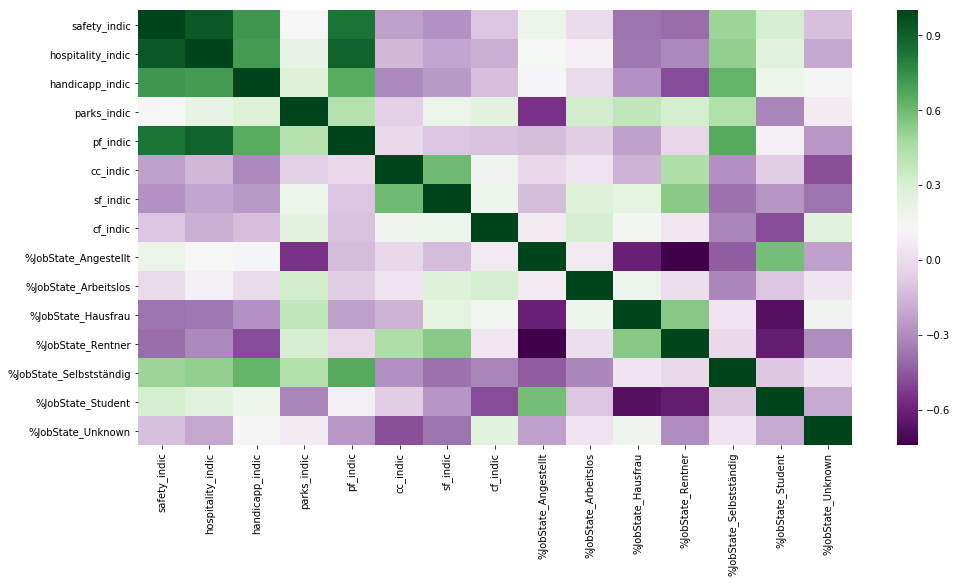

In [89]:
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(dfcoeff, 
        xticklabels=dfcoeff.columns,
        yticklabels=dfcoeff.columns, cmap='PRGn')


## Visualizing correlations

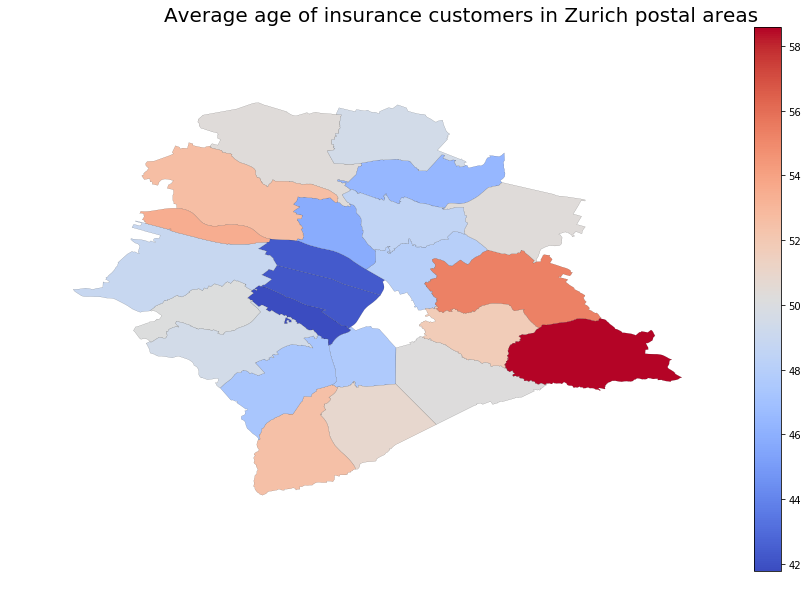

In [206]:
def display_map(gp, col_to_plot,title,colormap):
    '''
    This function creates a choropleth map using geopandas
    
    Parameters:
    gp = geodataframe data containing geometry column
    col_to_plot = column of data that must be plotted
    title = title of the map
    colormap = plt colormap to use, e.g. 'Blues', 'Accent', ...
    '''
    f, ax = plt.subplots(figsize=(15, 10))
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    
    # plotting settings
    ax.set_title(title, fontdict={'fontsize': '20', 'fontweight' : '500'})
    ax.set_aspect('equal')
    cax.set_aspect('equal')
    cax.set_axis_off()
    ax.set_axis_off()

    # get preferred colormap
    cmap = plt.cm.get_cmap(colormap)
    
    # plot data
    gp.plot(column=col_to_plot, ax=cax, linewidth=0.1, edgecolor='black',cmap=cmap)
    
    # create colorbar
    norm=plt.Normalize(vmin=gp[col_to_plot].min(), vmax=gp[col_to_plot].max())
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm._A = []
    f.colorbar(sm)
    
# use function defined above to create choropleth map 
display_map(gpd.GeoDataFrame(city_people_df), 'Avg_Age', 'Average age of insurance customers in Zurich postal areas','coolwarm')

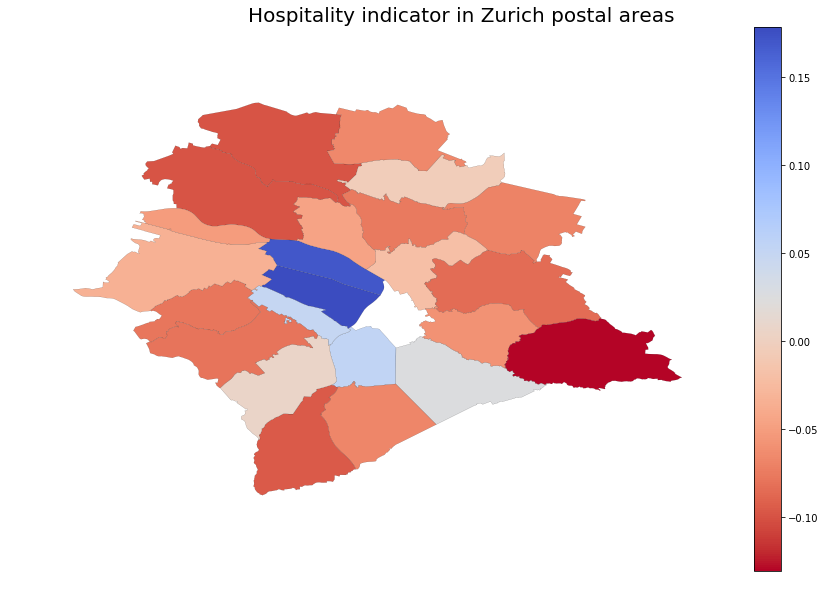

In [210]:
display_map(gpd.GeoDataFrame(city_people_df), 'hospitality_indic', 'Hospitality indicator in Zurich postal areas','coolwarm_r')

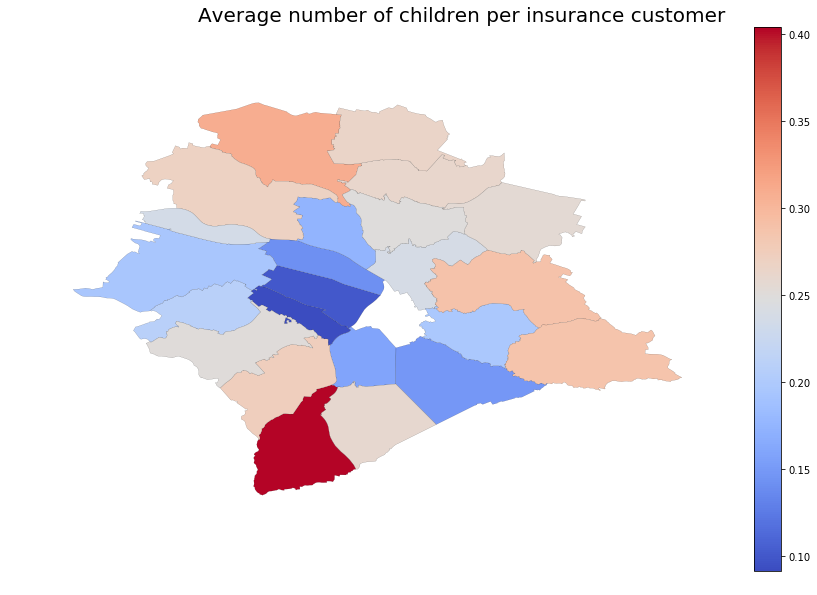

In [217]:
display_map(gpd.GeoDataFrame(city_people_df), 'Avg_Children_0-26', 'Average number of children per insurance customer','coolwarm')

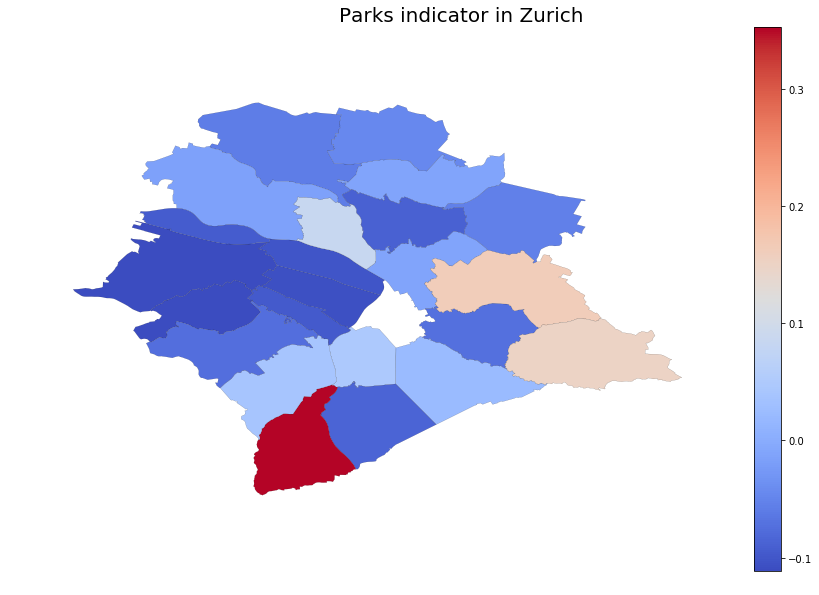

In [218]:
display_map(gpd.GeoDataFrame(city_people_df), 'parks_indic', 'Parks indicator in Zurich','coolwarm')

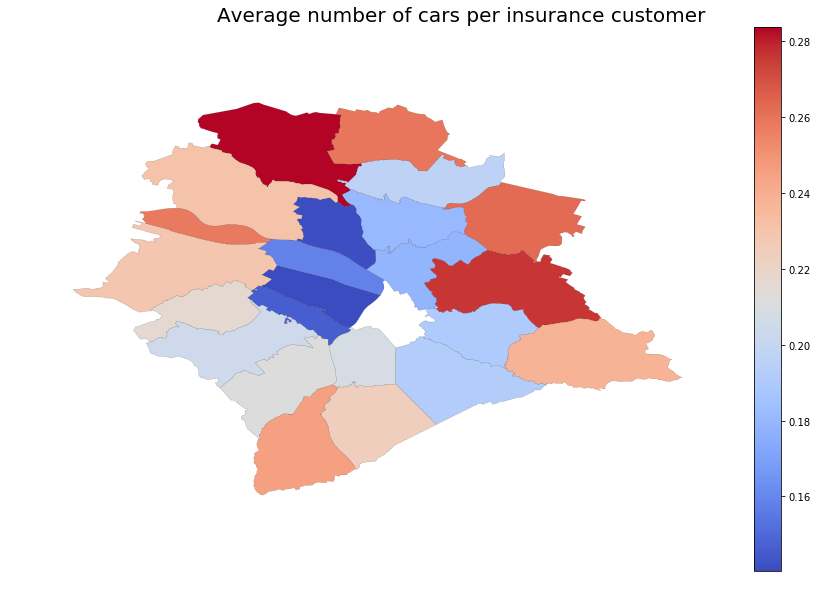

In [220]:
display_map(gpd.GeoDataFrame(city_people_df), 'Avg_num_cars', 'Average number of cars per insurance customer','coolwarm')

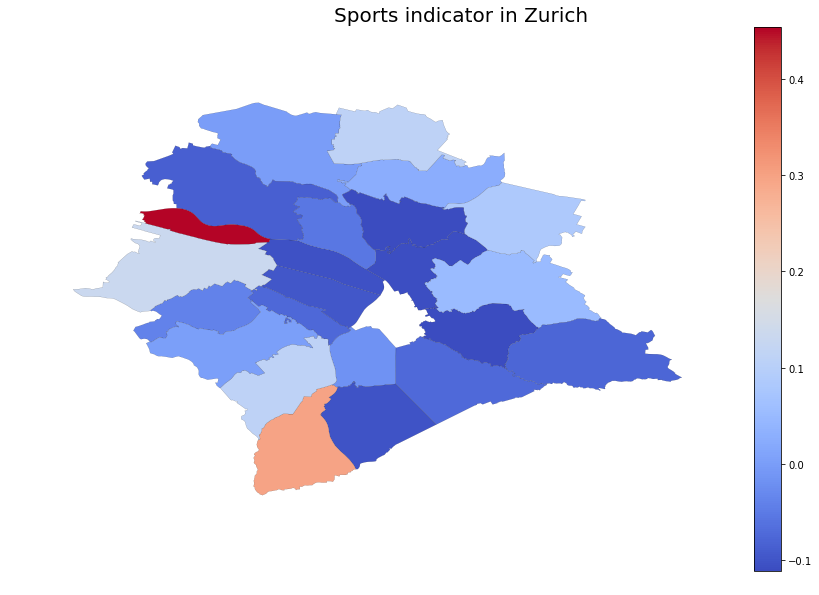

In [221]:
display_map(gpd.GeoDataFrame(city_people_df), 'sports_indic', 'Sports indicator in Zurich','coolwarm')

### How are the wealthy distributed?

In [202]:
# create spatial weights matrix
shapelist = city_people_df.geometry.tolist()
W = ps.weights.Queen.from_iterable(shapelist)

mi = ps.Moran(city_people_df.Avg_property_premium, W)
print(mi.I, mi.p_sim)


# get local spatial clustering metric
lisa = ps.Moran_Local(city_people_df.Avg_property_premium.values, W)

# get significant clusters
city_people_df['significant'] = lisa.p_sim < 0.05

# Store the quadrant they belong to
city_people_df['quadrant'] = lisa.q
city_people_df[['quadrant','significant']].head()

0.46417820638971075 0.001


,quadrant,significant
8002,4,False
8003,3,False
8004,3,True
8005,3,False
8006,1,False


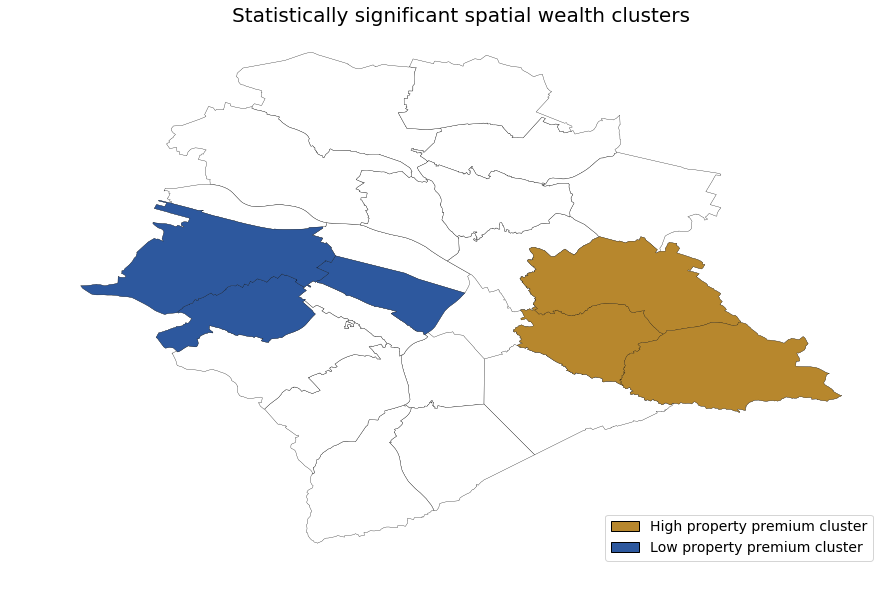

In [191]:
f, ax = plt.subplots(figsize=(15, 10))

# plotting settings
ax.set_title('Statistically significant spatial wealth clusters', fontdict={'fontsize': '20', 'fontweight' : '500'})
ax.set_aspect('equal')
ax.set_axis_off()

# plot data
city_people_gpd = gpd.GeoDataFrame(city_people_df)
city_people_gpd.plot(ax=ax,linewidth=0.3, edgecolor='black',color='White')
city_people_gpd.loc[(city_people_gpd['quadrant']==1) & (city_people_gpd['significant']==True)].plot(ax=ax,linewidth=0.2, edgecolor='black',color='#b7872d')
city_people_gpd.loc[(city_people_gpd['quadrant']==3) & (city_people_gpd['significant']==True)].plot(ax=ax,linewidth=0.2, edgecolor='black',color='#2d589e')
#city_people_gpd.loc[(city_people_gpd['quadrant']==2) & (city_people_gpd['significant']==True)].plot(ax=ax,linewidth=0.1, edgecolor='black',color='#83cef4')
#city_people_gpd.loc[(city_people_gpd['quadrant']==4) & (city_people_gpd['significant']==True)].plot(ax=ax,linewidth=0.1, edgecolor='black',color='#e59696')


from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#b7872d', edgecolor='k',
                         label='High property premium cluster'),
                   Patch(facecolor='#2d589e', edgecolor='k',
                         label='Low property premium cluster')]
plt.rcParams["legend.fontsize"] = 14
ax.legend(handles=legend_elements, loc='lower right')